In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')

#sys.path.append( '/home/cactuskid13/miniconda3/pkgs/')
print(sys.path)

['/scratch/dmoi/projects/HogProf/pyprofiler/notebooks', '/scratch/dmoi/condaenvs/ML2/lib/python39.zip', '/scratch/dmoi/condaenvs/ML2/lib/python3.9', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/lib-dynload', '', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages', '/scratch/dmoi/software/pyham', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/IPython/extensions', '/users/dmoi/.ipython', '../..']


In [3]:
#using the profiler. It's easy!
#lets import the profiler, configuration file and some tools for GO analysis to look at our returned results
from pyprofiler.utils import hashutils
import ete3
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.utils.hashutils as hashutils
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pyprofiler.profiler as profiler
import pandas as pd
import itertools
import pickle
from bloom_filter2 import BloomFilter

from sklearn.model_selection import train_test_split


{'dir': {'datadir': '/scratch/dmoi/datasets/birds/', 'omadir': '/scratch/dmoi/datasets/birds/'}, 'orthoxmltar': '', 'email': 'dmoi@unil.ch'}


In [4]:
#lets load a compiled db containing the OMA root HOGs into a profiler oject 
p = profiler.Profiler(lshforestpath = '/scratch/dmoi/datasets/all/newlshforest.pkl' , hashes_h5='/scratch/dmoi/datasets/birds/all/hashes.h5' , mat_path= None, oma = '/scratch/dmoi/datasets/OMA/apr2021/OmaServer.h5', tar= None , nsamples = 256 , mastertree = '/scratch/dmoi/datasets/birds/all_test_master_tree.pkl')

loading lsh
indexing lsh


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


3508
DONE


In [5]:
def grabHog(ID, verbose = True):
    try:
        entry = p.db_obj.entry_by_entry_nr(p.db_obj.id_resolver.resolve(ID))
        return entry[4].decode() , entry
    except:
        return np.nan,np.nan
#map to OMA HOGs

In [6]:
#load humap data
humap = '/scratch/dmoi/datasets/humap_PPI/humap2_ppis_ACC_20200821.pairsWprob'
humap_df = pd.read_table(humap, header = None)
print(humap_df)

                  0                1             2
0            P46926           Q8TDQ7  1.000000e+00
1            P43631           Q14954  1.000000e+00
2            P43631           Q14953  1.000000e+00
3            P43631           P43629  1.000000e+00
4         100287045           Q86YD7  1.000000e+00
...             ...              ...           ...
17526306     Q9H6Z4           Q7L1Q6  3.000000e-14
17526307     Q9Y265           P54578  3.000000e-14
17526308     P16152           P04406  3.000000e-14
17526309     Q96AE4           P78417  3.000000e-14
17526310     P20042  ENSG00000180574  3.000000e-14

[17526311 rows x 3 columns]


In [7]:
#filter to 90%proba
humap_df = humap_df[humap_df[2] > .75 ]
print(len(humap_df))
mapper = set( list(humap_df[1]) + list(humap_df[0]) )
mapper = { protid: grabHog(protid) for protid in mapper }
humap_df['hog1'] = humap_df[1].map(mapper)
humap_df['hog2'] = humap_df[0].map(mapper)

8981


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/_i_XRef/XRefId/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


In [8]:
humap_df['hogid_1'] = humap_df['hog1'].map(lambda x:x[0])
humap_df['hogid_2'] = humap_df['hog2'].map(lambda x:x[0])
humap_df = humap_df.dropna()
print(len(humap_df))

8576


In [9]:
humap_df['fam1'] = humap_df['hog1'].map( lambda x :   p.hogid2fam(x[1]) )
humap_df['fam2'] = humap_df['hog2'].map( lambda x :   p.hogid2fam(x[1]) ) 
humap_df = humap_df.dropna()
humap_df.fam1 = humap_df.fam1.map(int)
humap_df.fam2 = humap_df.fam2.map(int)
print(len(humap_df))

8360


In [10]:
humap_df.to_csv(humap+'hogmapped.csv')

In [11]:
humap_pairs = humap_df

In [12]:
allhogs = set([])
allhogs = allhogs.union( set(humap_df.fam1.unique() ) )
allhogs = allhogs.union( set(humap_df.fam2.unique() ) )
print(len(allhogs))

3168


In [13]:
profiles = {}
calc_hogs_humap = False
if calc_hogs_humap == True:
    for fam in allhogs:
        print(fam)
        try:
            prof = p.return_profile_OTF(fam)
        except:
            print('err', fam)
        print(prof)
        profiles.update(prof)

In [14]:
import pickle
save_Hogs_humap = False
if save_Hogs_humap == True:
    with open(humap + 'gold_standard_profiles.pkl' , 'wb') as profiles_out:
        profiles_out.write(pickle.dumps(profiles))

In [15]:
import pickle
with open(humap + 'gold_standard_profiles.pkl' , 'rb') as profiles_out:
    humap_profiles = pickle.loads(profiles_out.read())

In [15]:
humap_df = pd.DataFrame.from_dict(humap_profiles , orient = 'index')
print(humap_df.head())

                                                      mat  \
524288  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
516097  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
516099  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
786438  [[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,...   
573452  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                     tree  
524288  (((\n--7757)), ((\n--7764)), ((\n--9597)), ((\...  
516097  (((\n--9597)), ((\n--9598)), ((\n--9606)), ((\...  
516099  (((\n--9597)), ((\n--9598)), ((\n--9606)), ((\...  
786438  (((\n--868595)), ((\n--349161)), ((\n--696281)...  
573452  (((\n--120017)), ((\n--237631)), ((\n--1230383...  


In [37]:
import dask
from dask import dataframe as dd
coglink_df = dd.read_csv('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt', blocksize=25e6 , header = 0, sep = ' ')

In [38]:
print(coglink_df)
print(coglink_df.columns)

Dask DataFrame Structure:
                 group1  group2 neighborhood fusion cooccurence coexpression experimental database textmining combined_score
npartitions=195                                                                                                             
                 object  object        int64  int64       int64        int64        int64    int64      int64          int64
                    ...     ...          ...    ...         ...          ...          ...      ...        ...            ...
...                 ...     ...          ...    ...         ...          ...          ...      ...        ...            ...
                    ...     ...          ...    ...         ...          ...          ...      ...        ...            ...
                    ...     ...          ...    ...         ...          ...          ...      ...        ...            ...
Dask Name: read-csv, 195 tasks
Index(['group1', 'group2', 'neighborhood', 'fusion', 'cooccurence',


In [39]:
dropcols = ['neighborhood', 'fusion', 'cooccurence', 'combined_score' ]
coglink_df = coglink_df.drop(columns = dropcols)
coglink_df['score'] = coglink_df.coexpression + coglink_df.experimental +coglink_df.database+ coglink_df.textmining

In [40]:
coglink_df= coglink_df[coglink_df.score>1000]
print(len(coglink_df))
coglink_df = coglink_df.compute()

500428


In [41]:
print(coglink_df.head())

      group1   group2  coexpression  experimental  database  textmining  score
0    COG0001  COG0002            79             0       741         361   1181
4    COG0001  COG0007           105           424         0         529   1058
76   COG0001  COG0113           355             0       741         822   1918
130  COG0001  COG0181           213             0       741         822   1776
305  COG0001  COG0549             0             0       741         263   1004


In [20]:
grabcogs = set( list(coglink_df.group1.unique()) + list(coglink_df.group2.unique()) )

In [21]:
grabcogs= list(grabcogs)

In [22]:
print(len(grabcogs), grabcogs[0:100])

13067 ['NOG44845', 'KOG1922', 'NOG16100', 'NOG92000', 'KOG1990', 'COG5279', 'KOG3607', 'COG1310', 'NOG21851', 'NOG235396', 'NOG257797', 'NOG282766', 'NOG299870', 'COG0427', 'NOG43138', 'COG1167', 'COG2320', 'NOG20668', 'COG5038', 'KOG3530', 'NOG07466', 'NOG17097', 'NOG10955', 'KOG2612', 'NOG16976', 'KOG1452', 'COG1437', 'NOG03133', 'COG1394', 'NOG238267', 'NOG26389', 'COG5623', 'NOG273125', 'COG0721', 'NOG25743', 'COG0431', 'NOG04099', 'KOG0485', 'NOG18778', 'NOG71914', 'NOG12371', 'NOG254860', 'NOG235201', 'NOG254203', 'COG5197', 'KOG1517', 'NOG07543', 'NOG08833', 'NOG45310', 'COG0347', 'COG3555', 'KOG3145', 'KOG3638', 'NOG243276', 'COG3080', 'NOG37164', 'NOG48643', 'NOG16527', 'NOG15856', 'KOG2065', 'NOG269759', 'NOG06771', 'NOG06845', 'COG1240', 'NOG16738', 'COG0291', 'NOG270176', 'NOG01373', 'NOG23682', 'NOG02331', 'KOG0006', 'NOG08315', 'KOG2469', 'NOG271014', 'COG4115', 'KOG4704', 'NOG258245', 'COG3424', 'NOG15305', 'KOG4151', 'NOG237096', 'NOG218278', 'COG1260', 'KOG0845', 'KOG2

In [23]:
#map the interacting cogs to the proteins
COGmapings_df = dd.read_csv('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt', blocksize=25e6 , header = 0, sep = '\t')
COGmapings_df = COGmapings_df.set_index('orthologous_group')
COGmapings_df.astype(str)
COGmapings_df['##protein'].map( lambda x : x.strip() )
COGmapings_df['species'] = COGmapings_df['##protein'].map( lambda x : x.split('.')[0] )

COGmapings_df['COG'] = COGmapings_df.index
COGmapings_df = COGmapings_df.loc[grabcogs]

print(COGmapings_df.head())
COGmapings_df = COGmapings_df.compute()

                                       ##protein  start_position  \
orthologous_group                                                  
COG0006             1002340.AFCF01000062_gene798               1   
COG0006             1002340.AFCF01000067_gene239               1   
COG0006                    1028800.RG540_PA00120               1   
COG0006                    1028800.RG540_PA03140               1   
COG0006            1002340.AFCF01000054_gene1922               1   

                   end_position        protein_annotation  species      COG  
orthologous_group                                                            
COG0006                     390  annotation not available  1002340  COG0006  
COG0006                     596  annotation not available  1002340  COG0006  
COG0006                     410  annotation not available  1028800  COG0006  
COG0006                     380  annotation not available  1028800  COG0006  
COG0006                     396  annotation not availab

In [25]:
#only take the proteins in our cogs of interest
compute_grabcogs = False
if compute_grabcogs == True:
    grabprots =list(COGmapings_df['##protein'].unique())
    print(len(grabprots))
    with open('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt' + '.grabcogs.txt', 'w') as protsout:
        protsout.write(''.join([ p + '\n' for p in grabcogs ]) )
    with open('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt' + '.grabprots.txt' , 'w') as protsout:
        protsout.write(''.join([ p + '\n' for p in grabprots ]) )
else:
    with open('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt' + '.grabcogs.txt', 'r') as protsout:
        grabcogs = [ cog for cog in protsout.readlines()]
    with open('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt' + '.grabprots.txt' , 'r') as protsout:
        grabprots = [ prot for prot in protsout.readlines()]


In [27]:
import pickle
save_protlist = False

if save_protlist == True:
    print('establishng bloom filter for the proteins we want to keep from cogs of interest')
    #establish a filter for the prots
    protlist =  BloomFilter(max_elements=10**8, error_rate=0.001 ,start_fresh = True)
    #df['pair']= df.protein1.astype(str) + '_' + df.protein2.astype(str)
    
    for i,prot in enumerate(grabprots):
        if i % 100000 == 0:
            print(i/len(grabprots))
        protlist.add(prot.strip())
    print(protlist)
    with open('protbloom.pkl' , 'wb' ) as bloomout:
        bloomout.write(pickle.dumps(protlist))
    print('done')
else:
    with open('protbloom.pkl' , 'rb' ) as bloomout:
        protlist = pickle.loads(bloomout.read())
    print(protlist)
    

BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757)


In [28]:
print(grabprots[0].strip() ,grabprots[0].strip() in protlist )
print('crap','crap' in protlist)

1000565.METUNv1_01990 True
crap False


In [29]:
#establish cog2hog mapping
print(len(grabprots))

17064691


In [30]:
calc_mappers = False
import redis
rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
if calc_mappers == True:
    count = 0 
    for i,r in COGmapings_df.iterrows():
        rdb.set(r['##protein'], i)
        count+=1
        if count < 10:
            print(i+'\n',r)
        if count%1000000==0:
            print(count/len(COGmapings_df))
    #protmapper[r['##protein']] = i    
    #protmapper = dict( zip(COGmapings_df['##protein'] , COGmapings_df.index ) )
    #cogexample = dict( zip( COGmapings_df.index ,  COGmapings_df['##protein']   ) )
    
    #with open('cogmappers.pkl' , 'wb')as cogmappers_out:
    #    cogmappers_out.write(pickle.dumps((protmapper, cogexample)) )
#else:
#    with open('cogmappers.pkl' , 'rb')as cogmappers_out:
#        protmapper, cogexample = pickle.loads(cogmappers_out.read())

In [31]:
#print(len(grabcogs))
print(len(COGmapings_df))

17681656


In [32]:
maphogs = False
if maphogs == True:
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    hogmap = {}
    for i,prot in enumerate(grabprots):
        if i % 100000 == 0 :
            print(i/len(grabprots))
        cog = rdb.get(prot)
        if cog not in hogmap:
            mapped =  grabHog(prot)
            #retry until something maps
            if mapped[0] != np.nan and type(mapped[0]) == str :
                if len(mapped[0])>1 :
                    hogmap[cog] = mapped
    with open('stringhogmap.pkl' , 'wb')as hogmapout:
        hogmapout.write(pickle.dumps(hogmap))
else:
    with open('stringhogmap.pkl' , 'rb')as hogmapout:
        hogmap = pickle.loads(hogmapout.read())


In [33]:
print(len(hogmap))
for i, key in enumerate(hogmap):
    if i < 10:
        print(key, hogmap[key])

12761
b'COG0022' ('HOG:A0772469', (1134780, 359776777, 338, 36877, b'HOG:A0772469', b'A', 136963, 137976, -1, 0, b'Q9K3H1', 1080465110, 1015, b'6161cbb7b6aed10547b7c95555c1c63a', 60128051, 322, b'', -1, -1))
b'COG1071' ('HOG:A0780700.10b.7b', (3753108, 1179251817, 734, 598427, b'HOG:A0780700.10b.7b', b'A', 2952449, 2954650, -1, 0, b'F4GWD5', 3541508558, 2203, b'0eaa8538e27a234812d4b19c67f1f560', 234217123, 43, b'', -1, -1))
b'COG0508' ('HOG:A0757171.22b.54b.29a', (3288989, 1034223672, 469, 598421, b'HOG:A0757171.22b.54b.29a', b'A', 1363913, 1365319, 1, 0, b'G4R8Y9', 3105960004, 1408, b'3b9ecc15f5881cc16928ba7e6a656fe6', 205095449, 48, b'', -1, -1))
b'COG0462' ('HOG:A0780700', (14151364, 5935651032, 846, 598427, b'HOG:A0780700', b'supercontig_To_g48347', 2246, 4990, -1, 0, b'K0RIS8', 17821104459, 2539, b'8f2ac7bfb36b9ffe82ad5d8dc2410bae', 696068665, 22, b'', -1, -1))
b'COG4886' ('HOG:A0779810.2c.30a.12a.2a', (16107232, 6695185680, 411, 598444, b'HOG:A0779810.2c.30a.12a.2a', b'1', 160094

In [34]:
#add the HOGs to the COGdf
#grab the corresponding profiles
print(len(coglink_df))
try:
    coglink_df.group1  = coglink_df.group1.map( lambda x : x.encode())
    coglink_df.group2  = coglink_df.group2.map( lambda x : x.encode())
except:
    pass

coglink_df['hog1'] = coglink_df.group1.map(hogmap)
coglink_df['hog2'] = coglink_df.group2.map(hogmap)
coglink_df=coglink_df.dropna()
print(len(coglink_df))
print(coglink_df.head())

500428
495684
         group1      group2  coexpression  experimental  database  textmining  \
0    b'COG0001'  b'COG0002'            79             0       741         361   
4    b'COG0001'  b'COG0007'           105           424         0         529   
76   b'COG0001'  b'COG0113'           355             0       741         822   
130  b'COG0001'  b'COG0181'           213             0       741         822   
305  b'COG0001'  b'COG0549'             0             0       741         263   

     score                                               hog1  \
0     1181  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   
4     1058  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   
76    1918  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   
130   1776  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   
305   1004  (HOG:A0644867.20h, [1140353, 361560390, 442, 9...   

                                                  hog2  
0    (HOG:A0780127.8b, [1141676, 362003752, 343, 10

In [35]:
coglink_df['hogid_1'] = coglink_df['hog1'].map(lambda x:x[0])
coglink_df['hogid_2'] = coglink_df['hog2'].map(lambda x:x[0])

In [36]:
coglink_df['fam1'] = coglink_df['hog1'].map( lambda x :   p.hogid2fam(x[1]) )
coglink_df['fam2'] = coglink_df['hog2'].map( lambda x :   p.hogid2fam(x[1]) ) 

coglink_df.fam1 = coglink_df.fam1.map(int)
coglink_df.fam2 = coglink_df.fam2.map(int)


In [37]:
print(coglink_df)

               group1       group2  coexpression  experimental  database  \
0          b'COG0001'   b'COG0002'            79             0       741   
4          b'COG0001'   b'COG0007'           105           424         0   
76         b'COG0001'   b'COG0113'           355             0       741   
130        b'COG0001'   b'COG0181'           213             0       741   
305        b'COG0001'   b'COG0549'             0             0       741   
...               ...          ...           ...           ...       ...   
530407  b'arCOG09486'  b'NOG24221'           263             0       899   
530662  b'arCOG09486'  b'NOG49907'            65             0         0   
530951  b'arCOG09486'   b'COG3338'           568             0         0   
531432  b'arCOG09486'  b'NOG24221'           263             0       899   
531687  b'arCOG09486'  b'NOG49907'            65             0         0   

        textmining  score                                               hog1  \
0      

In [38]:
stringHOGs = set(coglink_df.fam1.unique()).union(set(coglink_df.fam2.unique()))

In [39]:
print(len(stringHOGs))

11890


In [40]:
coglink_df.to_csv('STRINGCOGS2OMAHOGS.csv')
stringPairs = coglink_df

In [41]:
#derive explicit profiles for our hogs of interest in string
calc_hogs_string = False
stringprofiles = {}
print('profiles to calclulate',len(stringHOGs))
if calc_hogs_string == True:
    for i,fam in enumerate(stringHOGs):
        if i % 100 ==0:
            print(i)
        try:
            prof = p.return_profile_OTF(fam)
            stringprofiles.update(prof)
        except:
            print('err',fam)

profiles to calclulate 11890


In [42]:
if calc_hogs_string == True:
    with open('/scratch/dmoi/datasets/STRING/' + 'gold_standard_profiles.pkl' , 'wb') as profiles_out:
        profiles_out.write(pickle.dumps(stringprofiles))

In [43]:
with open('/scratch/dmoi/datasets/STRING/' + 'gold_standard_profiles.pkl' , 'rb' )as profiles_out:
    stringprofiles = pickle.loads(profiles_out.read())

In [44]:
string_df = pd.DataFrame.from_dict(stringprofiles , orient='index')

In [45]:
#make the profiles for this small set of HOGs
for i, key in enumerate(stringprofiles):
    if i < 10:
        print(key,stringprofiles[key])

786432 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f70e1826d3)}
786433 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f70e3000f4)}
524294 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f70e52f3b5)}
786440 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f70e2ea17f)}
524299 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f71a7a7222)}
786448 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f71a7a18ac)}
786449 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f71a773670)}
786450 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f71a73d434)}
131092 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '1648030' (0x7f71a70ddf4)}
524309 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f71a70f20a)}


In [ ]:
#now we have profiles for all HUMAP and COG interactions
#String has interactions from each COG in different species.
#We need a way to check for the presence of interaction within a species for a COG
#for this we will create a bloom filter with all the interactions between our cogs

In [17]:
from dask.distributed import fire_and_forget
from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
from dask_jobqueue import SLURMCluster
from dask.distributed import  utils_perf
from dask.distributed import Client, LocalCluster
import dask
import redis
from bloom_filter2 import BloomFilter
import lzma
from dask import dataframe as dd
distributed = True

/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [18]:
if distributed == True:
    NCORE = 5
    print('deploying cluster')
    cluster = SLURMCluster(
        walltime='4:00:00',
        n_workers = NCORE,
        cores=NCORE,
        processes = NCORE,
        interface='ib0',
        memory="80GB",
        env_extra=[
        'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
        'conda activate ML2'
        ],
        scheduler_options={'interface': 'ens2f0' },
        #extra=["--lifetime", "3h55m", "--lifetime-stagger", "4m"]
    )
    print(cluster.job_script())
    
else:
    cluster = LocalCluster()
    client = Client(cluster)

deploying cluster
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -n 1
#SBATCH --cpus-per-task=5
#SBATCH --mem=75G
#SBATCH -t 4:00:00
source /scratch/dmoi/miniconda/etc/profile.d/conda.sh
conda activate ML2
/scratch/dmoi/condaenvs/ML2/bin/python -m distributed.cli.dask_worker tcp://10.203.100.103:36139 --nthreads 1 --nprocs 5 --memory-limit 14.90GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



In [19]:
if distributed == True:
    print(cluster)
    cluster.scale(jobs = 100)
    print(cluster.dashboard_link)
    client = Client(cluster , timeout='450s' , set_as_default=True )

SLURMCluster(af0360d8, 'tcp://10.203.100.103:36139', workers=0, threads=0, memory=0 B)
http://10.203.100.103:8787/status


In [20]:
#find which species each of the cogs has an interaction in
link_df = dd.read_csv('/scratch/dmoi/datasets/STRING/protein.physical.links.detailed.v11.5.txt', blocksize=100e6 , header = 0, sep = ' ')
print(link_df)

Dask DataFrame Structure:
                 protein1 protein2 experimental database textmining combined_score
npartitions=1560                                                                  
                   object   object        int64    int64      int64          int64
                      ...      ...          ...      ...        ...            ...
...                   ...      ...          ...      ...        ...            ...
                      ...      ...          ...      ...        ...            ...
                      ...      ...          ...      ...        ...            ...
Dask Name: read-csv, 1560 tasks


In [54]:
#compute bloom filters for protein pairs

@dask.delayed
def mapcogs(df ):
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    if type( df ) == tuple:
        df = df[0]
    protlist1 = list(df.protein1.map(lambda x:str(x).strip()))
    protlist2 = list(df.protein2.map(lambda x:str(x).strip()))
    protlist = list(set(protlist1+protlist2))
    data = rdb.mget(protlist)
    mapper = dict(zip(protlist, data) )
    df['COG1'] = df.protein1.map(mapper)
    df['COG2'] = df.protein2.map(mapper)
    df = df.dropna()
    df['COG1'] = df.COG1.map(lambda x:str(x).replace("b",'').replace("'",'').strip() )
    df['COG2'] = df.COG2.map(lambda x:str(x).replace("b",'').replace("'",'').strip() )
    df['species'] = df.protein1.map(lambda x:x.split('.')[0])
    df['coglinks'] = df.COG1 + '_' + df.COG2 + '_' + df.species
    return  list(df.coglinks.unique())

@dask.delayed
def return_filter(coglinks, verbose = True):
    if type( coglinks ) == tuple:
        coglinks = coglinks[0]
    #prots can only interact in one species...
    b=BloomFilter(max_elements=10**8, error_rate=0.001 ,start_fresh = True)
    for p in coglinks:
        b.add( p )
    #b.close()
    #b = lzma.compress( pickle.dumps(b) )
    return   b , len(coglinks)

@dask.delayed
def sumfilter(f1,f2, total ):
    if type( f1 ) == tuple:
        f1 = f1[0]
    if type( f2 ) == tuple:
        f2 = f2[0]
    #f1 = pickle.loads(lzma.decompress( f1) )
    #f2 = pickle.loads(lzma.decompress( f2 ) )
    f3 = f1.__ior__(f2)
    #f3 = lzma.compress( pickle.dumps(f3) )
    return f3 , total

In [55]:
partitions  = link_df.to_delayed()

d00 = dask.compute( partitions[100])
#d1 = dask.compute(reduce(partitions[1],remote_list))
d02 = dask.compute( mapcogs(d00) )
print(d02[0][0:100])

f1 =dask.compute( return_filter(d02))[0]
f_1 = pickle.loads(lzma.decompress( f1[0]  ) ) 

print('COG1756_COG0088_4113' in d02[0] )
print('COG1756_COG0088_4113' in f_1 )

d10 = dask.compute( partitions[500])
#d1 = dask.compute(reduce(partitions[1],remote_list))
d12 = dask.compute( mapcogs(d10) )
print(d12[0][0:100])

f2 = dask.compute( return_filter(d12))[0]
f_2 = pickle.loads(lzma.decompress( f2[0] ) )
print(type(f_2))

['COG1756_COG0088_4113', 'COG1756_COG1358_4113', 'COG1756_COG1889_4113', 'COG1756_COG2125_4113', 'COG1756_COG0612_4113', 'COG1756_COG5272_4113', 'COG1756_KOG1823_4113', 'COG1756_COG0098_4113', 'COG1756_COG0334_4113', 'COG1756_COG0048_4113', 'COG1756_COG1890_4113', 'COG1756_COG0539_4113', 'COG1756_COG1643_4113', 'COG1756_KOG1812_4113', 'COG1756_COG2051_4113', 'COG1756_COG0557_4113', 'COG1756_KOG2147_4113', 'COG1756_KOG0319_4113', 'COG1756_COG0096_4113', 'COG1756_KOG1332_4113', 'COG1756_COG4901_4113', 'COG1756_KOG4547_4113', 'COG1756_COG0049_4113', 'COG1756_COG2007_4113', 'COG1756_KOG2048_4113', 'COG1756_KOG0580_4113', 'COG1756_KOG3100_4113', 'COG1756_COG0100_4113', 'COG1756_COG0099_4113', 'COG1756_COG1498_4113', 'COG1756_KOG3320_4113', 'COG1756_COG2053_4113', 'COG1756_KOG1837_4113', 'KOG0800_COG5078_4113', 'KOG0800_COG5272_4113', 'KOG0800_KOG1872_4113', 'KOG0800_KOG0908_4113', 'KOG0800_COG1552_4113', 'KOG0800_KOG4248_4113', 'KOG0800_KOG2381_4113', 'KOG0800_KOG2827_4113', 'COG0484_COG044

TypeError: a bytes-like object is required, not 'BloomFilter'

In [ ]:
print('COG1756_COG0088_4113' in d12[0]  )
print('COG1756_COG0088_4113' in f_2 )
print('COG0642_COG5641_4565' in d12[0]  )
print('COG0642_COG5641_4565' in f_2 )

f3 = dask.compute(sumfilter(f1,f2 , 0 ) )[0]
f_3 = pickle.loads(lzma.decompress( f3[0] ) )

print('COG1756_COG0088_4113' in f_3 )
print('COG4886_COG0480_29730' in f_3 )


In [56]:
partitions  = link_df.to_delayed()
#print('reduce partitions')
#res = [ reduce(p,remote_list) for p in partitions ] 
#print('done')
print('map cogs')
res1 = [ mapcogs(p) for p in partitions ] 
print('done')
print('make filters')
res2 = [ return_filter(p) for p in res1 ] 

totalfilter = res2
print(len(totalfilter))
while len(totalfilter)>1:
    next_round= []
    
    for i in range(0,len(totalfilter),2):
        if i+1 < len(totalfilter):
            next_round.append( sumfilter( totalfilter[i][0] , totalfilter[i+1][0] , totalfilter[i][1]+totalfilter[i+1][1]  ) )
    
    if len(totalfilter) % 2 !=0:
        next_round.append(totalfilter[-1])
    totalfilter = next_round
    print(len(totalfilter))

#resfinal = dask.compute(totalfilter)

print('done')

map cogs
done
make filters
1560
780
390
195
98
49
25
13
7
4
2
1
done


In [57]:
resfinal = dask.compute(totalfilter)

In [53]:
client.cancel(resfinal)

NameError: name 'resfinal' is not defined

In [58]:
import pickle 
with open('bloomfinal.pkl' , 'wb' ) as finalout:
    finalout.write(pickle.dumps(resfinal))

In [59]:

with open('bloomfinal.pkl' , 'rb' ) as finalout:
    resfinal = pickle.loads(finalout.read())

In [66]:
print('COG1756_COG0088_4113' in resfinal[0][0][0])

True


In [13]:
print(resfinal)

resfinal = resfinal[0][0]

([(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 246221112)],)


In [18]:
#lets try it out. we should be able to find in which species two cogs interact with the bloom filter
print(resfinal)
cog1='COG0088'
cog2 ='COG1756'
coglink = cog1 + '_' + cog2 + '_'

In [18]:
coglinks_species = [ coglink+spec.name  for spec in p.tree.get_leaves()]
checklinks = [ coglink+spec in resfinal for spec in coglinks_species ]
links = [ l for l,c in list(zip(coglinks_species,checklinks))  if c== True  ]
print(links)

(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 246221112)
[]


In [ ]:
with open('filters.pkl' , 'wb' ) as filters:
    filters.write(pickle.dumps(res))

In [63]:
link_df['species'] = link_df['protein1'].map( lambda x : str(x).split('.')[0] )
#eliminate prots not in set with the first filter... proba of double false positive is .001^2

link_df['COG1'] = link_df.protein1.map(protmapper)
#dropna on COG1
link_df = link_df[~link_df['COG1'].isna()]
link_df['COG2'] = link_df.protein2.map(protmapper)
#dropna on COG2
link_df = link_df[~link_df['COG2'].isna()]
link_df=link_df.dropna()

In [ ]:
link_df = dask.persist(link_df)

In [ ]:
print(len(link_df))

In [ ]:
#write out subdf 
link_df.to_csv('filtered_links.csv')

In [ ]:
print(link_df.columns)

In [ ]:
#encdoe COG interactions as COG1_COG2_taxcode
link_df['coglinks'] = link_df.COG_x+'_'+link_df.COG_y+'_'+link_df.species

In [ ]:
from bloom_filter2 import BloomFilter
@dask.delayed
def return_filter(df):
    if type( df ) == tuple:
        df = df[0]
    b =  BloomFilter(max_elements=10**9, error_rate=0.001 ,start_fresh = True)
    #df['pair']= df.protein1.astype(str) + '_' + df.protein2.astype(str)
    pairs = [ p for p in list(df.coglinks)]
    for p in pairs:
        b.add( p )    
    return  b


In [ ]:
#compute bloom filters for protein pairs
partitions  = link_df.to_delayed()  
res = [ return_filter(p) for p in partitions ] 
print(len(res))

In [ ]:
res = dask.compute(*res)

In [ ]:
#treesum
@dask.delayed
def sumfilter(f1,f2):
    return f1.__ior__(f2)
totalfilter = res
print(len(totalfilter))
while len(totalfilter)>1:
    next_round= []
    for i in range(0,len(totalfilter),2):
        if i+1 < len(totalfilter):
            next_round.append( sumfilter( totalfilter[i],totalfilter[i+1]) )
    if len(totalfilter) % 2 !=0:
        next_round.append(totalfilter[-1])
    totalfilter = next_round
    print(len(totalfilter))

In [ ]:
print(totalfilter)

In [ ]:
final = dask.compute(totalfilter[0])

In [ ]:
#save the precious precious filter
with open('filtersig.pkl' , 'wb' ) as sigout:
    sigout.write(pickle.dumps(bloom))

In [49]:
print(len(res))

6238


In [50]:
print(res[0]== res[1])

True


In [12]:
#test bloom
print( '23.BEL05_11670_23.BEL05_00025' in bloom )
print( 'crap' in bloom )

False
False


In [ ]:
#defining ground truth for interaction emergence

In [ ]:
#prepare template tree
import dendropy
#find interactions between two orthgroups across the tree
tree = dendropy.Tree.get(path = treefile, schema="newick")
for i,l in enumerate(tree.leaf_nodes()):
        l.aln_row = i
for i,l in enumerate(tree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None

#t is a delayed obj...
def calc_interaction_on_taxonomy(tree, leafstates):
    #set interaction states
    for i,l in enumerate(tree.leaf_nodes()):
        l.char = leafstates[l.aln_row]
    print(interactions,interactions.shape)
    t = calculate_small_parsimony(tree, interactions)
    return t
t= t.compute()   

In [ ]:
#proceed by COG pairs
#find all prots in both COGS
#proceed by protpairs
#if protpair in bloom then the interaction exists
def iter_species(cogmap_df,COG1,COG2,bloom_filter):
    sub1 = cogmap_df[ cogmap_df.orthologous_group == COG1 ].compute()
    sub2 = cogmap_df[ cogmap_df.orthologous_group == COG2 ].compute()
    #join by species
    sub1['species']= 
    sub2['species']=
    #discard prots where no species is shared
    joined_df = sub1.merge(sub1 , left_on = 'species', right_on = 'species', how = '' )
    #check if protpairs are in bloom filter
    protpairs = joined_df[] + joined_df[]
    species_found = {}
    for pair in protpairs:
        if pair in bloom_filter:
            species_found.add(pair.split('.')[0])
    return species_found
#init the species tree with 0s other than where the cogs are interacting

In [ ]:
#fitch the ancestral states
#when one is absent the state in 0
import itertools
import sys
import dask

#the interaction either exists or it doesnt within a species
allowed_symbols =set([0,1])
transition_dict = { (c[0],c[1]):i for i,c in enumerate(itertools.permutations(allowed_symbols,2) ) }
print(allowed_symbols, transition_dict)
####small parsimony functions ##########
def process_node_smallpars_1(node):
    #go from leaves up and generate character sets
    if node.symbols is None:
        for child in node.child_nodes():
            if child.symbols is None:
                process_node_smallpars_1(child)
        node.symbols = { }
        node.scores = { }
        symbols = set.intersection( * [ child.symbols for child in node.child_nodes( ) ] )
        if len(symbols) == 0:
            symbols = set.union( * [ child.symbols for child in node.child_nodes( ) ] )
        node.symbols = symbols
        for c in allowed_symbols:
            if c not in node.symbols:
                #add trnasition mat here if needed
                score = min(  [ child.scores[c] for child in node.child_nodes()])+1
            else:
                score = min(  [ child.scores[c] for child in node.child_nodes() ] )
            node.scores[c] = score

def process_node_smallpars_2(node , verbose = False):
    #assign the most parsimonious char from children
    if node.char is None:
        if node.parent_node:
            #node has parent
            node.char = {}
            node.event = {}
            node.eventype= {}
            node.char = min(node.scores, key=node.scores.get)
            if node.parent_node.char == node.char:
                node.event = 0
            else:
                if node.scores[node.parent_node.char] == node.scores[node.char] :
                    node.char = node.parent_node.char
                    node.event = 0
                else:
                    node.event = 1
                    node.eventype = transition_dict[(node.parent_node.char,node.char)]
        else:
            #root node
            node.char = {}
            node.event= {}
            node.eventype = {}
            node.char = min(node.scores, key=node.scores.get)
            node.event = 0
        #down one level
        for child in node.child_nodes():
            if child.char is None:
                process_node_smallpars_2(child)

@dask.delayed(pure=False)
def calculate_small_parsimony(t , alncol  ,  bootstrap = None , position = 0 ):
    #df is 3 columns of a codons
    #setup the tree and matrix for each worker
    #assign leaf values
    #repeat here for bootstrap
    #change a subset of leaves to ambiguous characters
    for l in t.leaf_nodes():
        #setup for small_pars1
        l.event = 0
        l.scores = { c:10**10 for c in allowed_symbols }
        l.symbols =  allowed_symbols
        char = alncol[ l.aln_row ]
        if char in allowed_symbols:
            l.symbols = { char }
            l.scores[char] = 0
        else:
            char = None
            l.symbols =  allowed_symbols
        l.char = min(l.scores, key=l.scores.get)
    #upq
    process_node_smallpars_1(t.seed_node)
    #down
    process_node_smallpars_2(t.seed_node)
    #collect events
    eventdict = {}

    return t

In [75]:
#mapfam to matrow
humap_fam_map= { f:i for i,f in enumerate(humap_df.index)}
humap_profilemat = np.vstack(humap_df.mat)
print(humap_profilemat.shape)
string_fam_map = { f:i for i,f in enumerate(string_df.index)}
string_mat = np.vstack(string_df.mat)
print(string_mat.shape)
#train test split
Datasets = {}
for label,df,mapping,profilemat in [  ('string', stringPairs, string_fam_map ,string_mat ) , ('humap',humap_pairs, humap_fam_map , humap_profilemat) ]:
    
    keys = set(mapping.keys())
    entry1 = [ f in keys for f in df.fam1]
    df = df.iloc[entry1]
    entry2 = [ f in keys for f in df.fam2]

    df = df.iloc[entry2]
    msk = np.random.rand(len(df)) < 0.8
    df_train = df.iloc[msk]
    df_test = df.iloc[~msk]
    
    
    Datasets[label]={'Train':df_train,'Test':df_test , 'mapping': mapping , 'mat':profilemat }
    print(label)
    print('train',len(df_train))
    print('test',len(df_test))


(3145, 10524)
(3583, 10524)
string
train 10975
test 2709
humap
train 6638
test 1655


In [76]:

def chunks(df, n):
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]
def generateXYchunk(explicit_profiles, goldstandardDF,fam_map,  nsamples=100, posi_percent = .5):
    #shuffle
    goldstandardDF = goldstandardDF.sample(frac=1)
    for chunkdf in chunks(goldstandardDF , int( nsamples*posi_percent)):
        #negatives drawn from the overall dataset
        X = np.hstack([ np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam1]) , np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam2]) ] )
        Y = [1]* X.shape[0]
        neg1 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam1)
        neg2 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam2)
        
        if len(neg1)>0:
            mixchunk = np.hstack([np.vstack([profilemat[fam_map[f]] for f in neg1]),np.vstack([profilemat[fam_map[f]] for f in neg2])])
            Y =np.hstack([[0]* mixchunk.shape[0] , Y])
            X= np.vstack([mixchunk,X])    
        #positive samples
        yield X, Y

3508
nodes


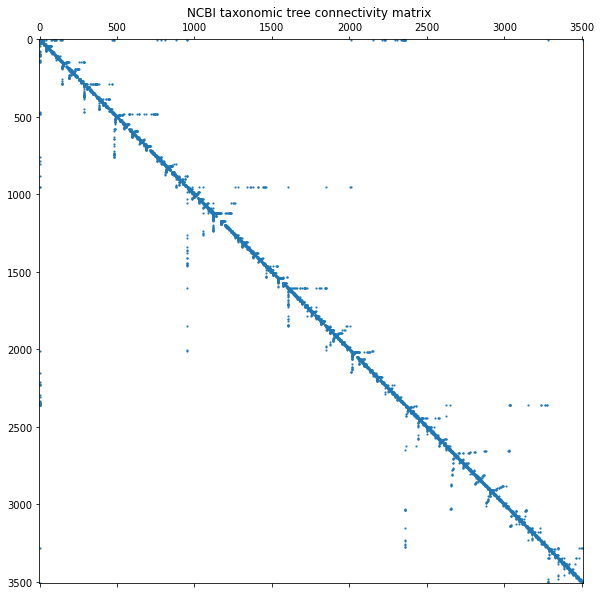

In [77]:
#save with mapped ids
import scipy
import dendropy
from matplotlib import pyplot as plt
species_tree = p.tree
with open('species_tree.nwk', 'w')as treeout:
    treeout.write( species_tree.write())
tree = dendropy.Tree.get( path='species_tree.nwk', schema='newick')
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')
#blur w connectivity mat
blurfactor =  .25
connectmat = scipy.sparse.lil_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1
sumlengths = connectmat.sum(axis=1)
#diag= scipy.sparse.diags(1,[0])
#connectmat += diag
connectmat = scipy.sparse.coo_matrix(connectmat)
plt.figure( figsize=(10,10))
plt.title( 'NCBI taxonomic tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()

In [78]:
import ete3
taxonomy = p.tree
taxmap ={ n:i for i,n in enumerate(taxonomy.traverse())}
reverse_taxmap = dict(zip(taxmap.values(), taxmap.keys()))

In [52]:
def generateXYchunk_blurred(explicit_profiles, goldstandardDF,fam_map,  connectmat, nsamples=100, posi_percent = .5 , nblurs = 10 ):
    #shuffle
    goldstandardDF = goldstandardDF.sample(frac=1)
    for chunkdf in chunks(goldstandardDF , int( nsamples*posi_percent)):
        #negatives drawn from the overall dataset
        
        for blur in range(nblurs):

            profiles1 = np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam1])
            profiles2= np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam2] )
            #divide into three categories
            
            #diffusion w const boundary conditions
            
            #separate the pair of 
            X= connectmat.dot(X)
        
        Y = [1]* X.shape[0]
        neg1 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam1)
        neg2 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam2)
        
        if len(neg1)>0:
            mixchunk = np.hstack([np.vstack([profilemat[fam_map[f]] for f in neg1]),np.vstack([profilemat[fam_map[f]] for f in neg2])])
            Y =np.hstack([[0]* mixchunk.shape[0] , Y])
            X= np.vstack([mixchunk,X])    
        #positive samples
        yield X, Y
    

In [98]:

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from cycler import cycler

def ROC_curve(y_data, label = None):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for l in y_data:
        print(l)
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        fpr, tpr, _ = roc_curve(   y_pred_grd ,y_test)
        plt.plot(fpr, tpr, label=l + 'auc'+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_ROC.svg' )
    plt.show()
    
    
    plt.figure(figsize=(10,10))
    for l in y_data:
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        precision, recall, thresholds = precision_recall_curve( y_pred_grd, y_test)
        plt.plot( recall, precision , label= l )
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    
    plt.title('PR curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_PR.svg' )
    plt.show()
    
def ROC_curve_single(y_test, y_pred_grd):
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, y_pred_grd)
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  y_test , y_pred_grd)
    plt.plot(precision, recall , label='single')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()


In [87]:
#try a vanilla deep NN
from keras.layers import Dense, Input
from keras.models import Sequential
import os
import tensorflow as tf
from keras.models import load_model

overwrite = True

for dataset in Datasets:
    modelpath = './'+label+'_dropout_DNN.h5'
    callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir= modelpath+'.logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=modelpath)
    ]
    print(dataset)
    df_train = Datasets[label]['Train']
    fam_map = Datasets[label]['mapping']
    profilemat = Datasets[label]['mat']
    if os.path.exists(modelpath) and overwrite == False:
        model = load_model(modelpath)
    else:
        model = Sequential()
        model.add(Dense(units=100, activation='sigmoid', input_dim=profilemat.shape[1]*2))
        model.add(tf.keras.layers.Dropout( .2 , seed=42 ))
        model.add(Dense(units=30, activation='sigmoid' ) )
        model.add(Dense(units=1, activation='sigmoid' ) )
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    generator = generateXYchunk(profilemat, df_train, fam_map , posi_percent= .5 , nsamples = 50 )
    sample = next(generator)


    model.fit(itertools.cycle(generator) , steps_per_epoch = 300 , epochs = 50, callbacks=callbacks)
    # Save the model
    model.save(modelpath)



string
Epoch 1/50
300/300 [==============================] - 7s 21ms/step - loss: 0.6486 - accuracy: 0.6312
Epoch 2/50
300/300 [==============================] - 5s 18ms/step - loss: 0.5900 - accuracy: 0.6902
Epoch 3/50
300/300 [==============================] - 5s 18ms/step - loss: 0.5593 - accuracy: 0.7118
Epoch 4/50
300/300 [==============================] - 5s 18ms/step - loss: 0.5415 - accuracy: 0.7266
Epoch 5/50
300/300 [==============================] - 5s 18ms/step - loss: 0.5297 - accuracy: 0.7299
Epoch 6/50
300/300 [==============================] - 5s 18ms/step - loss: 0.5118 - accuracy: 0.7441
Epoch 7/50
300/300 [==============================] - 5s 18ms/step - loss: 0.4962 - accuracy: 0.7563
Epoch 8/50
300/300 [==============================] - 5s 18ms/step - loss: 0.4865 - accuracy: 0.7645
Epoch 9/50
300/300 [==============================] - 5s 18ms/step - loss: 0.4742 - accuracy: 0.7758
Epoch 10/50
300/300 [==============================] - 5s 18ms/step - loss: 0.4617 -

In [87]:
#fit a model on blurred datasets
for dataset in Datasets:
    print(dataset)
    df_train = Datasets[label]['Train']
    fam_map = Datasets[label]['mapping']
    profilemat = Datasets[label]['mat']
    
    callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.TensorBoard(log_dir= modelpath+'.logs'),
    ]
        
    modelpath = './'+label+'_blurred_dropout_DNN.h5'
    if os.path.exists(modelpath):
        model = load_model(modelpath)
    else:
        model = Sequential()
        model.add(Dense(units=100, activation='sigmoid', input_dim=profilemat.shape[1]*2))
        model.add(tf.keras.layers.Dropout( .1 , seed=42 ))
        model.add(Dense(units=20, activation='sigmoid' ) )
        model.add(Dense(units=1, activation='sigmoid' ) )
    model.compile(loss='binary_crossentropy', optimizer='ADAGRAD', metrics=['accuracy'])
    generator = generateXYchunk_blurred(explicit_profiles, goldstandardDF,fam_map,  connectmat, nsamples=100, posi_percent = .5 , nblurs = 10 )
    sample = next(generator)
    model.fit_generator(itertools.cycle(generator) , steps_per_epoch = 3000 , epochs = 100,  callbacks=callbacks)
    # Save the model
    model.save(modelpath)

string


NameError: name 'explicit_profiles' is not defined

string
Euclidean
Hamming
Jaccard
Pearson
DNN
(5434, 21048)
(21048,)
{'Euclidean': {'Ypred': array([-38.20994635, -16.46207763, -23.3023604 , ..., -12.4498996 ,
       -14.14213562, -16.97056275]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Hamming': {'Ypred': array([-0.13616496, -0.06347396, -0.06812999, ..., -0.06071836,
       -0.03705815, -0.13207906]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Jaccard': {'Ypred': array([-0.96355775, -0.7011041 , -0.71235195, ..., -0.95955591,
       -0.46938776, -1.        ]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Pearson': {'Ypred': array([-0.0449238 , -0.02620872, -0.00338594, ...,  0.24178361,
        0.90457148,  0.50403868]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'DNN': {'Ypred': array([[0.26558483],
       [0.4927609 ],
       [0.15584156],
       ...,
       [0.99916923],
       [0.99540293],
       [0.9996957 ]], dtype=float32), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}}
Euclidean
Hamming
Jaccard
Pearson
DNN


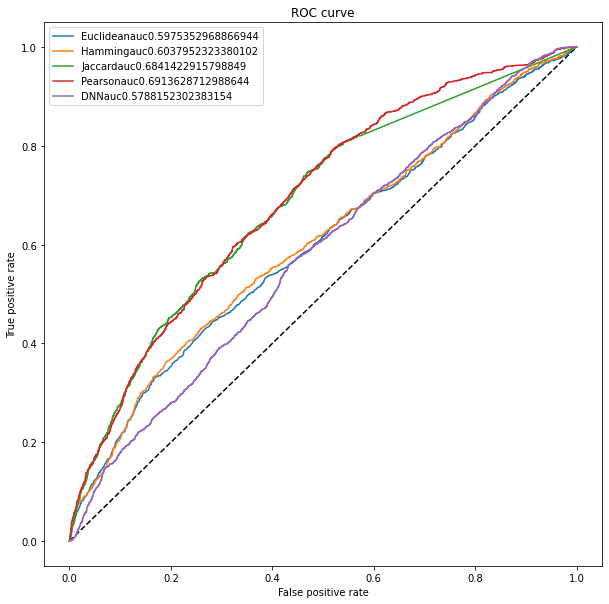

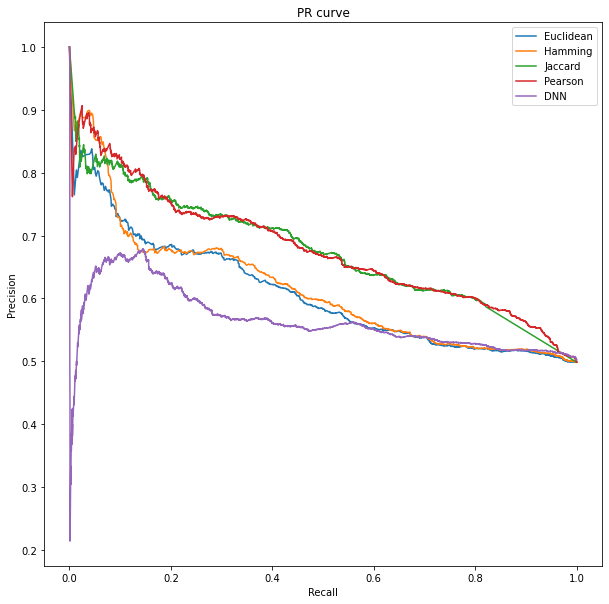

humap
Euclidean
Hamming
Jaccard
Pearson
DNN
(3330, 21048)
(21048,)
{'Euclidean': {'Ypred': array([-66.30233782, -23.        , -65.58200973, ..., -65.03076195,
       -14.76482306, -33.98529094]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Hamming': {'Ypred': array([-0.08105283, -0.03420753, -0.03933865, ..., -0.05368681,
       -0.0336374 , -0.02974154]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Jaccard': {'Ypred': array([-0.8990755 , -0.89202091, -0.83560545, ..., -0.80756686,
       -0.88903366, -0.53139357]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Pearson': {'Ypred': array([0.26235699, 0.86068834, 0.18111379, ..., 0.43812432, 0.76407524,
       0.1041981 ]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'DNN': {'Ypred': array([[0.04479706],
       [0.00482899],
       [0.00224611],
       ...,
       [0.9528651 ],
       [0.9207498 ],
       [0.9565439 ]], dtype=float32), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}}
Euclidean
Hamming
Jaccard
Pearson
DNN


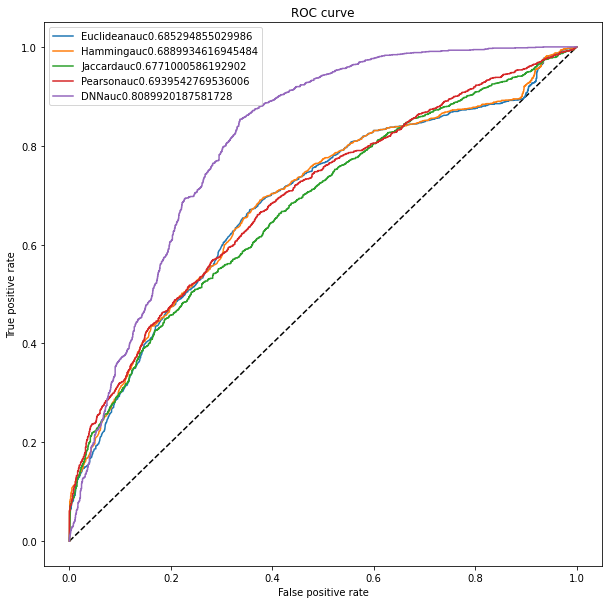

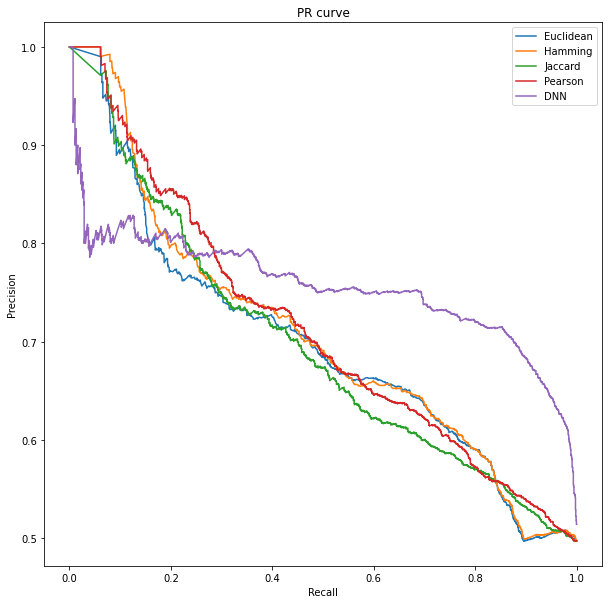

In [101]:
#normal distance metrics to try

from scipy.spatial.distance import euclidean , hamming, jaccard
from sklearn.covariance import empirical_covariance
from scipy.stats import pearsonr
from keract import get_activations
def pearsonR(v1,v2):
        return -pearsonr(v1,v2)[0]

for label in Datasets:
    print(label)
    df_test = Datasets[label]['Test']
    fam_map = Datasets[label]['mapping']
    profilemat = Datasets[label]['mat']
    ydata =  {}

    for func, name in [ (euclidean, 'Euclidean' ), (hamming,'Hamming') , (jaccard,'Jaccard') , (pearsonR,'Pearson') ]:
        print(name)
        generator = generateXYchunk(profilemat, df_test, fam_map , posi_percent= .5 , nsamples = 50 )
        #test all the easy metrics
        ypreds = []
        ytruth = []
        for X,y in generator:
            #distances
            x1 = X[:,0:int(X.shape[1]/2)]
            x2 = X[:,int(X.shape[1]/2):]
            predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
            ypreds.append(predictions)
            ytruth.append(y)
        ytest= np.hstack(ytruth)
        ypred = np.hstack(ypreds)
        ydata[name] = { 'Ypred': ypred , 'Ytrue':ytest} 
    #get DNN values
    print('DNN')
    generator = generateXYchunk(profilemat, df_test, fam_map , posi_percent= .5 , nsamples = 50 )
    mats = [(x,y) for x,y in generator ]
    X_test = np.vstack([x for x,y in mats])
    y_test = np.hstack([y for x,y in mats])
    
    
    modelpath = './'+label+'_dropout_DNN.h5'
    if os.path.exists(modelpath):
        model = load_model(modelpath)
    ypred = model.predict(X_test)
    
    activations = get_activations(model, X_test , auto_compile=True)
    activations = activations[list(activations.keys())[0]]
    print( activations.shape)
    n_samples = activations.shape[0]
    activations = np.sum(activations,axis =0)/n_samples
    representations = np.sum(X_test, axis = 0)
    
    print(activations.shape)
    
    np.save(modelpath + 'activation.np' , activations)
    np.save(modelpath + 'representation.np', representations)
    
    ydata['DNN'] ={ 'Ypred': ypred , 'Ytrue':ytest}
    #plot ROC
    print(ydata)
    ROC_curve(ydata , label = label)
    plt.show()


In [ ]:
#retrain the DNN for blurred dataset


In [ ]:
#try with blurring using the connectivity map / graph laplacian


generator = generateXYchunk(explicit_profiles, gold_standard , posi_percent= .5 , nsamples = 50 )
#test all the easy metrics
for X,y in generator:
    #distances
    
    #DNN
    



In [ ]:
#see the model activation!
#load models

#which taxa are the most informative for human
for label in Datasets:
    gen = generateXYchunk(explicit_profiles, gold_standard , posi_percent= .5 , nsamples = 50 )
    activations = np.vstack([ get_activations(model, x, auto_compile=True) for x,y in gen])
    n_samples = activations.shape[0]
    activations = np.sum(activations,axis =0)/n_samples
    #paint activations to each node of the species tree
    
    #visualize


In [ ]:
#test the interaction detection power of just the jkern first

import multiprocessing as mp
#generate submatrices for inversion

hashes = p.pull_hashes(fams)


def yieldpairs(hashes):
    for i,h1 in enumerate(hashes):
        for j,h2 in enumerate(hashes):
            if i < j:
                yield [i,j,h1,h2]
def distance(work):
    i,j,h1,h2 = work
    return [i,j,h1.jaccard(h2)]

pool = mp.Pool()
hashes = list(hashes.values())
res = pool.map_async( distance , yieldpairs(hashes)).get()
i,j, dist = zip(*res)
jkern = np.zeros( (len(hashes),len(hashes)))
jkern[i,j]=dist
jkern += jkern.T
np.fill_diagonal(jkern, 1)

pool.close()

In [ ]:

sns.heatmap(jkern)
plt.show()

sns.heatmap(connectmat_binary)
plt.show()



ROC_curve_single( connectmat_binary.ravel()  , jkern.ravel() )

#ROC_curve_single(connectmat_binary.ravel() , predmat.ravel() )


In [ ]:
pip install tf2_gnn

In [ ]:
#bonus graph neural networks

#encode phylogenies as graphs

#make sandwhich layer


#train graph nn receptive field


#predict on human node

#predict on several nodes
#use string data and get all interaction interlogs

#propagate the feature of interaction using fitch in sandwhich layer

#compare AUC in different branches

